In [ ]:
import os
import json
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, InputExample
from transformers.training_args import TrainingArguments
from transformers.trainer import Trainer
from transformers import AutoTokenizer, AutoConfig
from transformers.modeling_utils import PreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.utils.data import Dataset as TorchDataset
from datasets import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)

DATA_PROCESSED_PATH = "../data/processed"
TRAINING_DATA_FILE = "retriever_training_data.jsonl"
MODEL_BASE_NAME = "BAAI/bge-base-en-v1.5" 
FINETUNED_MODEL_SAVE_PATH_TRAINER = "../models/retriever_finetuned"

NUM_EPOCHS = 5
TRAIN_BATCH_SIZE_PER_DEVICE = 16
EVAL_BATCH_SIZE_PER_DEVICE = 32
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

TRAIN_RATIO = 0.80
VALIDATION_RATIO = 0.10
TEST_RATIO = 0.10

LOGGING_STEPS = 10
EVALUATION_STEPS = 50
SAVE_STEPS = 50

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

training_data_path = os.path.join(DATA_PROCESSED_PATH, TRAINING_DATA_FILE)
os.makedirs(FINETUNED_MODEL_SAVE_PATH_TRAINER, exist_ok=True)
TRAINING_LOGS_PATH_TRAINER = os.path.join(FINETUNED_MODEL_SAVE_PATH_TRAINER, "training_logs")
os.makedirs(TRAINING_LOGS_PATH_TRAINER, exist_ok=True)

if not os.path.exists(training_data_path):
    raise FileNotFoundError(f"Training file not found: {training_data_path}")

print(f"Using device: {DEVICE}")
print("Config loaded.")

Using device: cuda
Using device: cuda
Config loaded.


In [2]:
all_input_examples = []
with open(training_data_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading all data"):
        data = json.loads(line)
        all_input_examples.append(InputExample(texts=[data['query'], data['passage']], label=float(data['label'])))

print(f"Loaded {len(all_input_examples)} data")
if not all_input_examples: raise ValueError("Data not loaded.")

train_input_examples, temp_input_examples = train_test_split(
    all_input_examples, test_size=(1.0 - TRAIN_RATIO), random_state=42, stratify=[s.label for s in all_input_examples]
)
val_input_examples, test_input_examples = train_test_split(
    temp_input_examples, test_size=TEST_RATIO / (VALIDATION_RATIO + TEST_RATIO), random_state=42, stratify=[s.label for s in temp_input_examples]
)

print(f"Train dataset size: {len(train_input_examples)}")
print(f"Valid dataset size: {len(val_input_examples)}")
print(f"Test dataset size: {len(test_input_examples)}")

def convert_input_examples_to_dict_list(examples):
    return [{"sentence1": ex.texts[0], "sentence2": ex.texts[1], "labels": ex.label} for ex in examples]

train_data_dict = convert_input_examples_to_dict_list(train_input_examples)
val_data_dict = convert_input_examples_to_dict_list(val_input_examples)
test_data_dict = convert_input_examples_to_dict_list(test_input_examples)

train_dataset = Dataset.from_list(train_data_dict)
val_dataset = Dataset.from_list(val_data_dict)
test_dataset = Dataset.from_list(test_data_dict)

print("\nDataset example:")
print(train_dataset[0])

Loading all data: 0it [00:00, ?it/s]

Loaded 4700 data
Train dataset size: 3760
Valid dataset size: 470
Test dataset size: 470

Dataset example:
{'sentence1': 'when is vikings season 5 part 2 starting', 'sentence2': "WrestleMania 41 took place on April 19 and 20, 2025, at Allegiant Stadium in the Las Vegas suburb of Paradise, Nevada. While still roughly in mid-April, this is the latest April date for a WrestleMania, which subsequently marks the first WrestleMania to be held during Easter weekend. Following tradition, the WrestleMania Weekend festivities included a live WrestleMania SmackDown (including the André the Giant Memorial Battle Royal) immediately followed by the 2025 WWE Hall of Fame induction ceremony on Friday April 18, then on the afternoon of Saturday April 19, NXT's Stand & Deliver event. A post WrestleMania edition of Raw on Monday April 21 followed, with all WrestleMania week festivities concluding with the Tuesday April 22 episode of NXT. SmackDown, Stand & Deliver and Raw all took place at the nearby T-M

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE_NAME)

class SentenceTransformerWrapper(PreTrainedModel):
    def __init__(self, model_name_or_path):
        config = AutoConfig.from_pretrained(model_name_or_path) 
        super().__init__(config)
        
        self.sbert_model = SentenceTransformer(model_name_or_path)

    def forward(self, sentence1_features, sentence2_features, labels=None, **kwargs):
       
        embeddings1 = self.sbert_model(sentence1_features)['sentence_embedding']
        embeddings2 = self.sbert_model(sentence2_features)['sentence_embedding']
        
        loss = None
        if labels is not None:
            cosine_scores = F.cosine_similarity(embeddings1, embeddings2)
            transformed_labels = labels.clone().view(-1)
            transformed_labels[transformed_labels == 0] = -1
            
            loss_fct_cosine_embedding = nn.CosineEmbeddingLoss(margin=0.0)
            loss = loss_fct_cosine_embedding(embeddings1, embeddings2, transformed_labels)
            
            return SequenceClassifierOutput(loss=loss, logits=cosine_scores)
        else:
            cosine_scores = F.cosine_similarity(embeddings1, embeddings2)
            return SequenceClassifierOutput(logits=cosine_scores)
            
    def save_pretrained(self, save_directory, **kwargs):
        """Saves model (Sequence Transformer)."""
        self.sbert_model.save(save_directory)

sbert_wrapper_model = SentenceTransformerWrapper(MODEL_BASE_NAME)

def tokenize_function(examples):
    s1_tok = tokenizer(examples['sentence1'], padding="max_length", truncation=True, max_length=128)
    s2_tok = tokenizer(examples['sentence2'], padding="max_length", truncation=True, max_length=128)
    
    return {
        'sentence1_features': {"input_ids": s1_tok['input_ids'], "attention_mask": s1_tok['attention_mask']},
        'sentence2_features': {"input_ids": s2_tok['input_ids'], "attention_mask": s2_tok['attention_mask']},
        'labels': examples['labels']
    }

print("Tokenizing datasets...")

class SentencePairDataset(TorchDataset):
    def __init__(self, examples, tokenizer, max_length=128):
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        tokenized_s1 = self.tokenizer(ex.texts[0], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        tokenized_s2 = self.tokenizer(ex.texts[1], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        
        item = {
            'input_ids_s1': tokenized_s1['input_ids'].squeeze(0),
            'attention_mask_s1': tokenized_s1['attention_mask'].squeeze(0),
            'input_ids_s2': tokenized_s2['input_ids'].squeeze(0),
            'attention_mask_s2': tokenized_s2['attention_mask'].squeeze(0),
            'labels': torch.tensor(ex.label, dtype=torch.float)
        }
        if 'token_type_ids' in tokenized_s1:
            item['token_type_ids_s1'] = tokenized_s1['token_type_ids'].squeeze(0)
        if 'token_type_ids' in tokenized_s2:
            item['token_type_ids_s2'] = tokenized_s2['token_type_ids'].squeeze(0)
        return item


train_torch_dataset = SentencePairDataset(train_input_examples, tokenizer, max_length=256) # max 512
val_torch_dataset = SentencePairDataset(val_input_examples, tokenizer, max_length=256)
test_torch_dataset = SentencePairDataset(test_input_examples, tokenizer, max_length=256)


class SentenceTransformerTrainerWrapper(PreTrainedModel):
    def __init__(self, model_name_or_path):
        from transformers import AutoConfig
        config = AutoConfig.from_pretrained(model_name_or_path)
        super().__init__(config)
        self.sbert_model = SentenceTransformer(model_name_or_path)

    def forward(self, input_ids_s1, attention_mask_s1, input_ids_s2, attention_mask_s2, 
                token_type_ids_s1=None, token_type_ids_s2=None, labels=None, **kwargs):
        
        features_s1 = {'input_ids': input_ids_s1, 'attention_mask': attention_mask_s1}
        if token_type_ids_s1 is not None: features_s1['token_type_ids'] = token_type_ids_s1
        
        features_s2 = {'input_ids': input_ids_s2, 'attention_mask': attention_mask_s2}
        if token_type_ids_s2 is not None: features_s2['token_type_ids'] = token_type_ids_s2
            
        embeddings1 = self.sbert_model(features_s1)['sentence_embedding']
        embeddings2 = self.sbert_model(features_s2)['sentence_embedding']
        
        loss = None
        logits = F.cosine_similarity(embeddings1, embeddings2)
        
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits, labels.view(-1))
            
        return SequenceClassifierOutput(loss=loss, logits=logits)

    def save_pretrained(self, save_directory, **kwargs):
        self.sbert_model.save(save_directory)

sbert_wrapper_model_for_trainer = SentenceTransformerTrainerWrapper(MODEL_BASE_NAME)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    validation_loss = mean_squared_error(labels, predictions)

    binary_preds = (predictions >= 0.5).astype(int)
    binary_labels = (labels >= 0.5).astype(int) 
    accuracy = accuracy_score(binary_labels, binary_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='binary', zero_division=0)

    return {
        "loss": validation_loss,
        "accuracy_at_0.5_thresh": accuracy,
        "f1_at_0.5_thresh": f1,
        "precision_at_0.5_thresh": precision,
        "recall_at_0.5_thresh": recall,
    }

print("Prepared model and tokenization for Trainer.")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Tokenizing datasets...
Prepared model and tokenization for Trainer.


In [4]:
training_args = TrainingArguments(
    output_dir=FINETUNED_MODEL_SAVE_PATH_TRAINER,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE_PER_DEVICE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO, 
    logging_dir=os.path.join(FINETUNED_MODEL_SAVE_PATH_TRAINER, 'logs'),
    logging_steps=LOGGING_STEPS,
    eval_strategy="steps",
    eval_steps=EVALUATION_STEPS, 
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_at_0.5_thresh",
    greater_is_better=True,
    report_to="tensorboard",
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
)

trainer = Trainer(
    model=sbert_wrapper_model_for_trainer,
    args=training_args,
    train_dataset=train_torch_dataset,
    eval_dataset=val_torch_dataset,
    compute_metrics=compute_metrics,
)

print("\nStarted fine-tuningu retrievera...")
train_result = trainer.train()

print("Fine-tuning finished.")
print(f"Train logs and metrics saved to: {training_args.logging_dir}")
print(f"Best model saved to: {trainer.state.best_model_checkpoint}")
print("You can delete rest of the models/checkpoints.")


Started fine-tuningu retrievera...


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Accuracy At 0.5 Thresh,F1 At 0.5 Thresh,Precision At 0.5 Thresh,Recall At 0.5 Thresh
50,0.182700,0.183534,0.780851,0.744417,0.738916,0.750000
100,0.166000,0.157193,0.806383,0.723404,0.922481,0.595000
150,0.161200,0.141833,0.855319,0.830846,0.826733,0.835000
200,0.154500,0.131170,0.838298,0.802083,0.836957,0.770000
250,0.106700,0.126600,0.842553,0.813131,0.821429,0.805000
300,0.093300,0.120456,0.848936,0.820253,0.830769,0.810000
350,0.098400,0.120640,0.861702,0.838710,0.832512,0.845000
400,0.105200,0.114935,0.865957,0.837209,0.866310,0.810000
450,0.106400,0.114948,0.874468,0.851385,0.857868,0.845000
500,0.063200,0.114970,0.853191,0.820779,0.854054,0.790000


INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-50
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-100
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-150
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-200
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-250
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-300
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-350
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base/checkpoint-400
INFO:sentence_transformers.SentenceTransformer:Save model to ../models/retriever_trainer_bge_base

Fine-tuning finished.
Train logs and metrics saved to: ../models/retriever_trainer_bge_base/logs
Best model saved to: ../models/retriever_trainer_bge_base/checkpoint-450
You can delete rest of the models/checkpoints.


In [18]:
test_metrics = trainer.evaluate(eval_dataset=test_torch_dataset)
print(f"Test set metrics: {test_metrics}")

test_metrics_path = os.path.join(TRAINING_LOGS_PATH_TRAINER, "test_metrics.json")
with open(test_metrics_path, "w") as f:
    json.dump(test_metrics, f, indent=4)
print(f"Test metrics saved to: {test_metrics_path}")

Test set metrics: {'eval_loss': 0.09526162594556808, 'eval_accuracy_at_0.5_thresh': 0.8808510638297873, 'eval_f1_at_0.5_thresh': 0.8578680203045685, 'eval_precision_at_0.5_thresh': 0.8711340206185567, 'eval_recall_at_0.5_thresh': 0.845, 'eval_runtime': 1.3432, 'eval_samples_per_second': 349.911, 'eval_steps_per_second': 11.167, 'epoch': 5.0}
Test metrics saved to: ../models/retriever_trainer_bge_base/training_logs/test_metrics.json


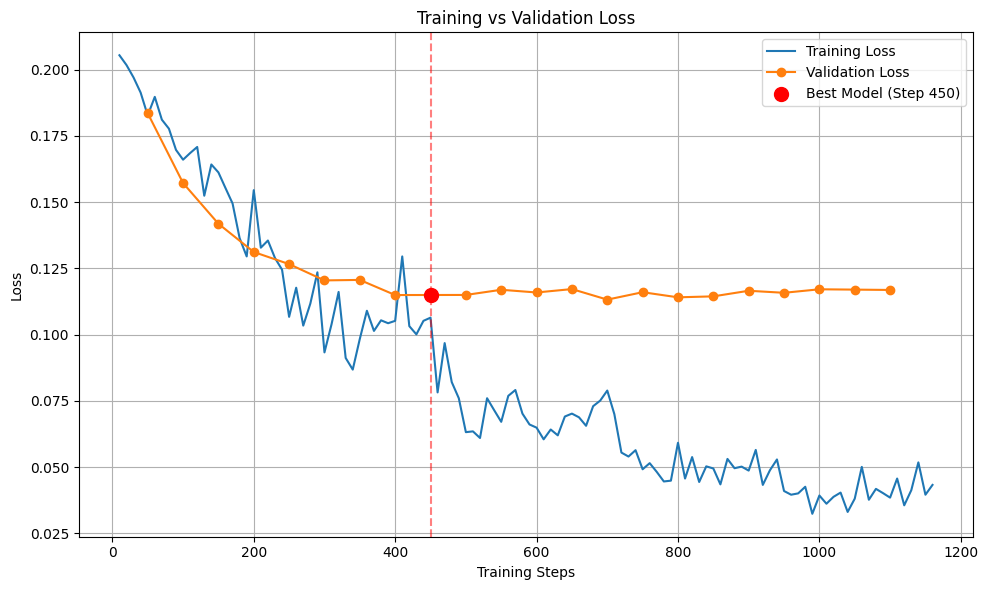

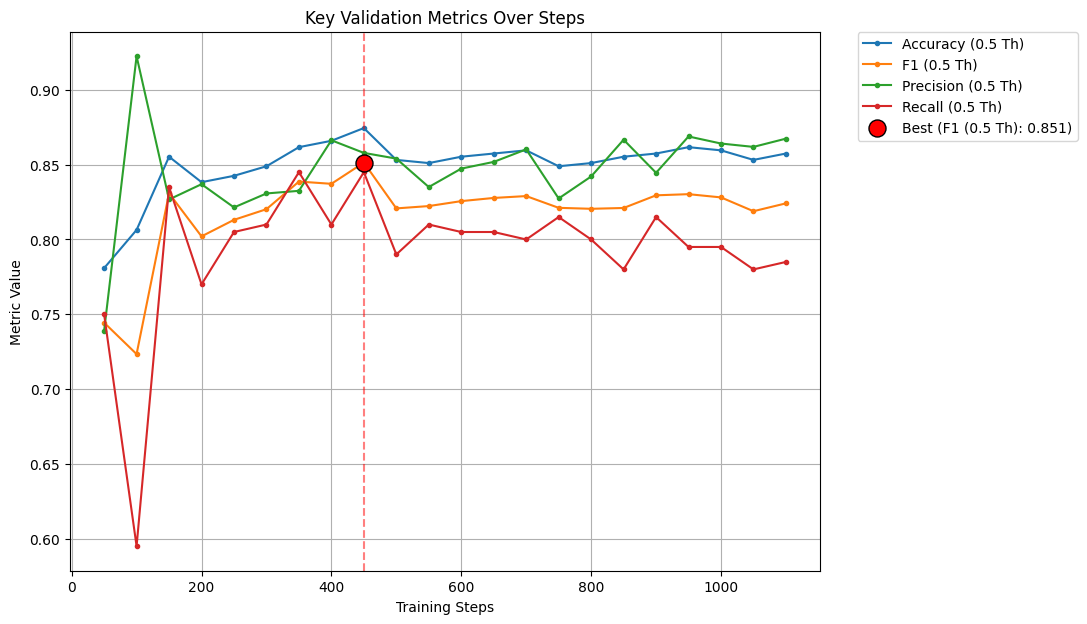

In [ ]:
log_df = pd.DataFrame(trainer.state.log_history)

train_logs = log_df[log_df['loss'].notna() & log_df['eval_loss'].isna()]
eval_logs = log_df[log_df['eval_loss'].notna()]
train_logs = train_logs[:-1] # don't display last log element as at the end the best model is loaded
eval_logs = eval_logs[:-1]

best_checkpoint_step = None
if trainer.state.best_model_checkpoint:
    try:
        best_step_str = trainer.state.best_model_checkpoint.split('-')[-1]
        if best_step_str.isdigit():
            best_checkpoint_step = int(best_step_str)
    except Exception:
        pass

plt.figure(figsize=(10, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss', marker='o')

best_log_entry = eval_logs[eval_logs['step'] == best_checkpoint_step]
if not best_log_entry.empty:
    best_eval_loss = best_log_entry['eval_loss'].iloc[0]
    plt.scatter(best_checkpoint_step, best_eval_loss, color='red', s=100, zorder=5, label=f'Best Model (Step {best_checkpoint_step})')
    plt.axvline(x=best_checkpoint_step, color='red', linestyle='--', alpha=0.5)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(TRAINING_LOGS_PATH_TRAINER, "train_val_loss_plot.png"))
plt.show()


metrics_to_plot = [
    'eval_accuracy_at_0.5_thresh',
    'eval_f1_at_0.5_thresh',
    'eval_precision_at_0.5_thresh',
    'eval_recall_at_0.5_thresh',
]

plt.figure(figsize=(12, 7))
lines_drawn = {}

for metric_col_key in metrics_to_plot:
    label_name = metric_col_key.replace("eval_", "").replace("_at_0.5_thresh", " (0.5 Th)").replace("_", " ").title()
    plt.plot(eval_logs['step'], eval_logs[metric_col_key], label=label_name, marker='.')
    lines_drawn[label_name] = line 

best_metrics_log_entry_for_this_step = eval_logs[eval_logs['step'] == best_checkpoint_step]
metric_key_for_best = training_args.metric_for_best_model
best_metric_value = best_metrics_log_entry_for_this_step[metric_key_for_best].iloc[0]

best_metric_display_label = metric_key_for_best.replace("eval_", "").replace("_at_0.5_thresh", " (0.5 Th)").replace("_", " ").title()
plt.scatter(best_checkpoint_step, best_metric_value, 
            color='red', 
            edgecolor='black', 
            s=150,
            zorder=5,
            label=f'Best Model ({best_metric_display_label}: {best_metric_value:.3f})')
plt.axvline(x=best_checkpoint_step, color='red', linestyle='--', alpha=0.5)

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.title("Key Validation Metrics Over Steps")

if plt.gca().has_data():
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
plt.grid(True)
plt.subplots_adjust(right=0.75)

plt.savefig(os.path.join(TRAINING_LOGS_PATH_TRAINER, "val_metrics_plot.png"))
plt.show()

In [15]:
import shutil

original_best_checkpoint_path = trainer.state.best_model_checkpoint

if os.path.exists(original_best_checkpoint_path):
    source_parent_dir = os.path.dirname(original_best_checkpoint_path)
    new_best_model_folder_name = "best-model"
    new_best_model_path = os.path.join(FINETUNED_MODEL_SAVE_PATH_TRAINER, new_best_model_folder_name)

    # delete old 'best-model' dir
    if os.path.exists(new_best_model_path):
        try:
            shutil.rmtree(new_best_model_path)
            print(f"Successfuly deleted old {new_best_model_folder_name} dir.")
        except Exception as e:
            print(f"Error while deleting old {new_best_model_folder_name} dir: {e}")

    # rename folder
    if not os.path.exists(new_best_model_path):
        try:
            shutil.move(original_best_checkpoint_path, new_best_model_path)
            print(f"Succesfully renamed dir '{original_best_checkpoint_path}' to '{new_best_model_path}'")
            
        except Exception as e:
            print(f"Error while renaming dir '{original_best_checkpoint_path}' to '{new_best_model_path}': {e}")
else:
    print(f"Best model directory {original_best_checkpoint_path} doesn't exist. Aborting.")

Best model directory ../models/retriever_trainer_bge_base/checkpoint-450 doesn't exist. Aborting.


In [13]:
from huggingface_hub import HfApi, upload_folder

api = HfApi()

folder_path_to_upload = str(trainer.state.best_model_checkpoint)
repo_id = "Kapturz0ny/wiki-retriver"

try:
    api.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)

    print(f"Uploading files from {folder_path_to_upload} to {repo_id}...")
    upload_folder(
        folder_path=folder_path_to_upload,
        repo_id=repo_id,
        repo_type="model",
        commit_message="Upload fine-tuned retriever model"
    )
    print("Upload finished")
except Exception as e:
    print(f"Error while uploading: {e}")

Uploading files from ../models/retriever_trainer_bge_base/checkpoint-450 to Kapturz0ny/wiki-retriver...


rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/871M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.71k [00:00<?, ?B/s]

Upload finished
